In [1]:
import tarfile

# open file
file = tarfile.open('/kaggle/input/flower-dataset-102/102flowers.tgz')

# extracting file
file.extractall('./data')
file.close()
del file

In [2]:
import scipy.io
import pandas as pd
from glob import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np


import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
pip install tflearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.3/107.3 kB 1.2 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for tflearn: filename=tflearn-0.5.0-py3-none-any.whl size=127283 sha256=57127a25410fbd249e63d9d2c25d39b6f83b88953eea086bc63caed79726cce3
  Stored in directory: /root/.cache/pip/wheels/55/fb/7b/e06204a0ceefa45443930b9a250cb5ebe31def0e4e8245a465
Successfully built tflearn
Note: you may need to restart the kernel to use updated packages.


In [5]:
import cv2
import tensorflow as tf
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import *
from sklearn.model_selection import train_test_split

from sklearn.utils.class_weight import compute_class_weight
import imageio

In [7]:
IMG_Size = 256
IMG_channels = 3
CLASS_NUM = 102
input_shape = (IMG_Size,IMG_Size,IMG_channels)
batch_size = 32
path = "/kaggle/working/"

In [54]:
mat = scipy.io.loadmat('/kaggle/input/flower-dataset-102/imagelabels.mat')
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 15:43:33 2009',
 '__version__': '1.0',
 '__globals__': [],
 'labels': array([[77, 77, 77, ..., 62, 62, 62]], dtype=uint8)}

In [55]:
mat['labels'] = mat['labels'].reshape(-1,)
labels = pd.DataFrame(mat['labels'], columns = ["labels"])
labels['labels'] = labels['labels']-1

del mat

In [109]:
print(labels.info())
labels.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8189 entries, 0 to 8188
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   labels  8189 non-null   uint8
dtypes: uint8(1)
memory usage: 8.1 KB
None


,labels
0,76
1,76
2,76
3,76
4,76


<Axes: ylabel='Frequency'>

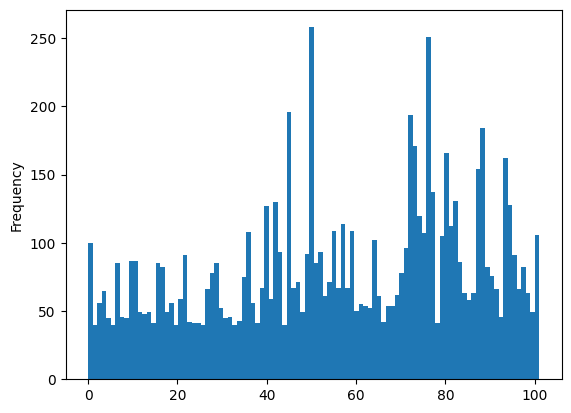

In [118]:
labels["labels"].plot(kind = "hist" ,bins = 100)

In [58]:
files = glob("data/jpg/*.jpg")
files.sort()


In [59]:
paths = pd.DataFrame(files, columns = ["path"])

In [61]:
df = pd.concat([paths,labels],axis = 1, ignore_index=True)

In [62]:
df = df.rename(columns={0: 'img_path', 1: "label"})
df['label']= df['label'].astype("string")

In [63]:
df.head()

,img_path,label
0,data/jpg/image_00001.jpg,76
1,data/jpg/image_00002.jpg,76
2,data/jpg/image_00003.jpg,76
3,data/jpg/image_00004.jpg,76
4,data/jpg/image_00005.jpg,76


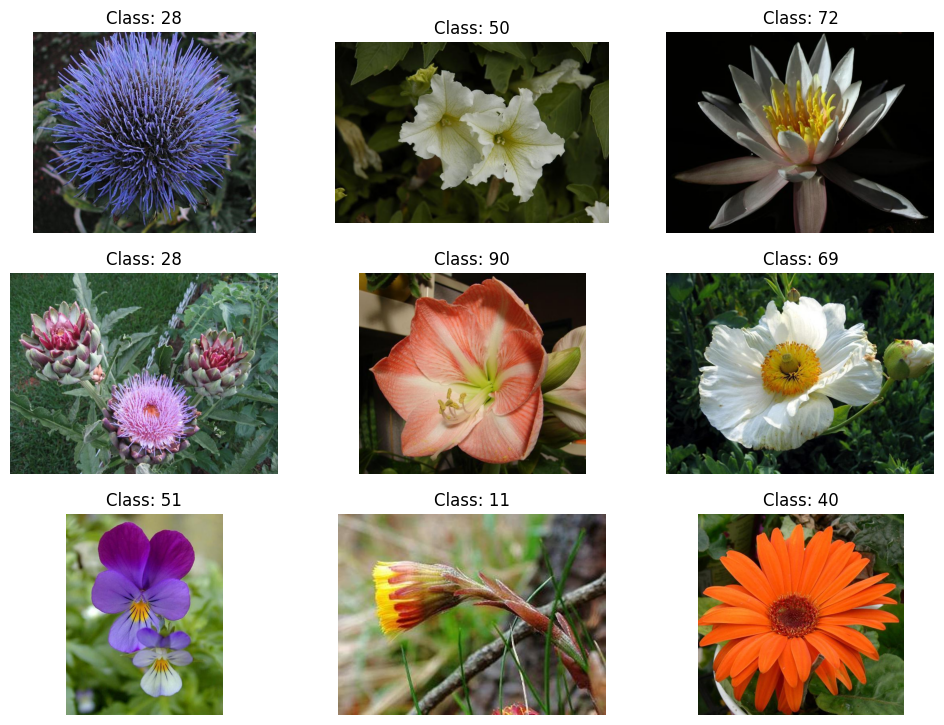

In [129]:
import PIL
from PIL import ImageOps, ImageFilter
plt.figure(figsize = (12, 12))

random_image = df.sample(n = 9)
random_paths = random_image['img_path'].values
random_label = random_image['label'].values

for index, p in enumerate(random_paths):
    ax = PIL.Image.open(p)
    plt.subplot(4, 3, index + 1)
    plt.imshow(ax)
    plt.title("Class: " + str(random_label[index]))
    plt.axis("off")

plt.show();

In [64]:
random_seed = 55
tr_va, Test_df = train_test_split(df,test_size=0.10,random_state=random_seed,stratify=df["label"])
Train_df, Valid_df = train_test_split(tr_va,test_size=0.15,random_state=random_seed,stratify=tr_va["label"])


In [19]:
print(Train_df["label"].value_counts())

1
50    206
76    201
45    157
72    155
88    147
     ... 
20     32
0      32
2      32
6      32
33     32
Name: count, Length: 102, dtype: int64


In [114]:
print(Valid_df["label"].value_counts())

label
50    35
76    34
45    26
72    26
88    25
      ..
44     5
26     5
33     5
6      5
0      5
Name: count, Length: 102, dtype: Int64


In [115]:
print(Test_df["label"].value_counts())

label
50    26
76    25
45    20
72    19
88    18
      ..
31     4
33     4
9      4
38     4
66     4
Name: count, Length: 102, dtype: Int64


In [65]:
#apply augmentation on training set only to genralize our model
train_datagen = ImageDataGenerator(rescale=1. / 255, 
                            rotation_range = 50,
                            shear_range=0.15,
                            zoom_range=[0.75,1.25],
                            brightness_range=[0.75, 1.5],
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            horizontal_flip=True,
                            validation_split=0.15)
test_datagen = ImageDataGenerator(rescale = 1. / 255)

In [66]:
train_generator = train_datagen.flow_from_dataframe(dataframe = Train_df, directory = path, x_col = 'img_path', y_col = "label",
                                                    target_size = (IMG_Size, IMG_Size), batch_size = batch_size, class_mode = 'categorical',
                                                    shuffle = True, seed = 42)

valid_generator = test_datagen.flow_from_dataframe(dataframe = Valid_df, directory = path, x_col = 'img_path', y_col = "label", 
                                                  target_size = (IMG_Size, IMG_Size), batch_size = batch_size, class_mode = 'categorical',
                                                 shuffle = False, seed = 42)
test_generator = test_datagen.flow_from_dataframe(dataframe = Test_df, directory = path, x_col = 'img_path', y_col = "label", 
                                                  target_size = (IMG_Size, IMG_Size), batch_size = batch_size, class_mode = 'categorical',
                                                 shuffle = False, seed = 42)

Found 6264 validated image filenames belonging to 102 classes.
Found 1106 validated image filenames belonging to 102 classes.
Found 819 validated image filenames belonging to 102 classes.


Image Train example:


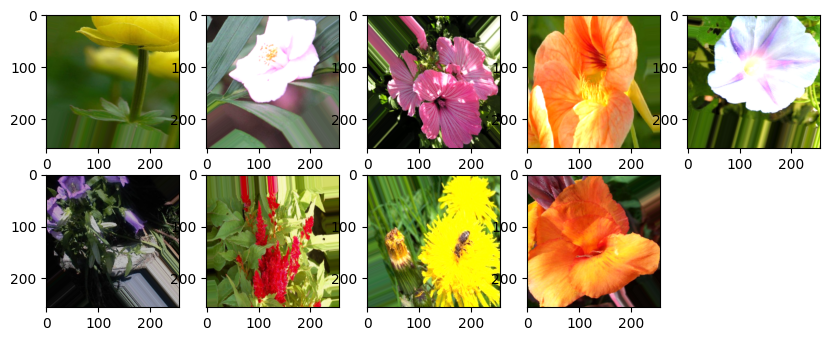

In [130]:
img, label = train_generator.next()
print("Image Train example:")
plt.figure(figsize = (10, 10))

for i in range(0, 9):
    image = img[i]
    plt.subplot(5,5, i + 1)
    plt.imshow(image) 

plt.show();

# **ResNet50**

In [85]:
base_model2 = tf.keras.applications.ResNet50V2(weights = 'imagenet', include_top = False, input_shape = input_shape)


In [131]:
base_model2.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 130, 130, 64)         0         ['conv1_conv[0][0]']          
                                                                                         

In [134]:
model3 = tf.keras.models.Sequential()
model3.add(base_model2)
model3.add(tf.keras.layers.GlobalAveragePooling2D())
#model3.add(tf.keras.layers.Dense(256, activation='relu'))
#model3.add(tf.keras.layers.Dropout(0.5))
model3.add(tf.keras.layers.Dense(CLASS_NUM,activation='softmax'))

In [135]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 102)               208998    
                                                                 
Total params: 23773798 (90.69 MB)
Trainable params: 23728358 (90.52 MB)
Non-trainable params: 45440 (177.50 KB)
_________________________________________________________________


In [136]:
model3.compile(loss = 'categorical_crossentropy', optimizer = "Adamax", metrics = ["accuracy"])

In [137]:
checkpoint = ModelCheckpoint('best_model.hdf5', monitor = ['val_accuracy'], verbose = 1, mode = 'max')
earlystop = EarlyStopping(monitor = 'val_accuracy', patience = 5, restore_best_weights = True)
callbacks_list = [checkpoint, earlystop]

In [138]:
scores = model3.evaluate(test_generator, steps = 1, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Accuracy: 3.12%


In [98]:
history = model3.fit_generator(train_generator,
                              steps_per_epoch = train_generator.samples // train_generator.batch_size,
                              validation_data = valid_generator, 
                              validation_steps= valid_generator.samples // test_generator.batch_size,
                              epochs = 25,
                              callbacks = callbacks_list)

Epoch 1/25


/tmp/ipykernel_47/2898477522.py:1: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model3.fit_generator(train_generator,


195/195 [==============================] - ETA: 0s - batch: 97.0000 - size: 31.9590 - loss: 1.8460 - acc: 0.5619
Epoch 1: saving model to best_model.hdf5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


195/195 [==============================] - 134s 604ms/step - batch: 97.0000 - size: 31.9590 - loss: 1.8460 - acc: 0.5619 - val_loss: 0.8282 - val_acc: 0.7887
Epoch 2/25
195/195 [==============================] - ETA: 0s - batch: 97.0000 - size: 31.9590 - loss: 0.5987 - acc: 0.8366
Epoch 2: saving model to best_model.hdf5
195/195 [==============================] - 120s 619ms/step - batch: 97.0000 - size: 31.9590 - loss: 0.5986 - acc: 0.8366 - val_loss: 0.5751 - val_acc: 0.8462
Epoch 3/25
195/195 [==============================] - ETA: 0s - batch: 97.0000 - size: 31.9590 - loss: 0.3599 - acc: 0.9048
Epoch 3: saving model to best_model.hdf5
195/195 [==============================] - 119s 609ms/step - batch: 97.0000 - size: 31.9590 - loss: 0.3599 - acc: 0.9048 - val_loss: 0.5818 - val_acc: 0.8562
Epoch 4/25
195/195 [==============================] - ETA: 0s - batch: 97.0000 - size: 31.9590 - loss: 0.2537 - acc: 0.9312
Epoch 4: saving model to best_model.hdf5
195/195 [======================

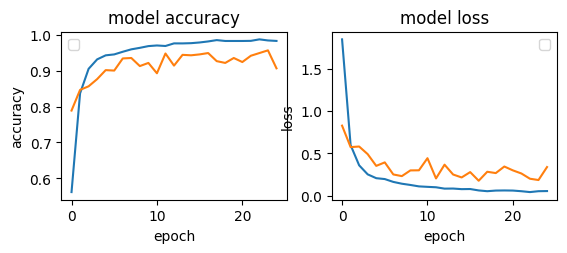

In [99]:
# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.legend();

In [100]:
scores = model3.evaluate_generator(test_generator, steps = 1, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

/tmp/ipykernel_47/2317901085.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model3.evaluate_generator(test_generator, steps = 1, verbose = 1)


Accuracy: 90.62%


In [107]:
#try to load the model after save
test_model = tf.keras.models.load_model("/kaggle/working/best_model.hdf5")

In [108]:
scores = test_model.evaluate_generator(test_generator, steps = 1, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

/tmp/ipykernel_47/4039235989.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = test_model.evaluate_generator(test_generator, steps = 1, verbose = 1)
/opt/conda/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Accuracy: 90.62%
